In [1]:
from Model import Model
import pandas as pd
import numpy as np
import itertools
import shap
from sklearn.model_selection import train_test_split
from Parameters import Parameters

t = Parameters('ranf').training_reg_params

%load_ext autoreload
%autoreload 2

In [2]:
model = Model('ranf')

In [3]:
# Y = pd.read_excel('../../Frame_Analysis/Microsoft Ad Optimization-AI Data_Survey Aggregated Data 21062019.xlsx',sheet_name="Sheet2")
# ub = Y[['Video Name','Unaided Branding']].groupby(['Video Name','Unaided Branding'])
# Y_ub = ub.first()

In [4]:
X,Y = model.preprocessing.load_data('./Agg_data_from_frame_295.xlsx',labels=False,sheet_name="Sheet1")
Y = model.preprocessing.load_Y('./Agg_Unaided.xlsx',video_name=False,column_name="same")

In [5]:
Y['Unaided_Branding'] = Y.iloc[1:]
Y = Y.drop('Unnamed: 1',1)
Y = Y.iloc[1:]

In [6]:
X = X.set_index(X['Video Name'])
# X = X.drop('Unnamed: 0',1)
# Y_old['Video Name'] = Y_old.index.values
# Y_new['Video Name'] = Y_new.index.values

# Y_new = Y_new[Y_new['Video Name']!= 'Surface Laptop_UK_30_Courtney v2 US VO_TV']
# Y_new = Y_new[Y_new['Video Name']!='284 Surface Laptop_UK_30_Courtney v2 US VO_TV' ]
# Y_new = Y_new.drop('Video Name',1)
# Y = pd.concat((Y_old,Y_new),axis=1)
X = X.loc[X['Campaign']=='Surface']
Y = Y.loc[X.index.values,:]

In [7]:
Y.dropna(how='all')
X = X.drop('Song for Surface NFL Fans - Surface SP4 30 TV US',0)
X,Y= model.preprocessing.clean_data(X,Y)

In [8]:
surface_pro_frames = [col for col in X.columns if "Surface Pro".lower() in col.lower()]
for suf in ['_dur','_first_ocr','_last_ocr','_total_ocr']:
    cols = [col+suf for col in surface_pro_frames[:10]]
    X = model.preprocessing.addNewFeature(X,cols,_type="sum",new_column_name="Surface"+suf)
X = X.drop(surface_pro_frames,axis=1)

In [9]:
frame_count_columns = [col for col in X.columns.values if '_dur' in col]
columns_removed =[]
for x in X.columns.values:
    if '_frame_count' in x:
        columns_removed.append(x)
cols = [col[:-12] for col in columns_removed]
for x in frame_count_columns:
#     if x+'_dur' in X.columns.values or '_frame_count' in x:
    if x[:-4] not in cols:
        columns_removed.append(x[:-4])
columns_removed.remove('Intel')
columns_removed.remove('Surface')

In [10]:
X = X.drop(columns=columns_removed,axis=1)
columns_removed

['Female_frame_count',
 'Male_frame_count',
 'Age: 5-15_frame_count',
 'Age: 0-5_frame_count',
 'Age: 15-24_frame_count',
 'Age: 25-34_frame_count',
 'Age: 35-44_frame_count',
 'Age: 45-60_frame_count',
 'Angry_frame_count',
 'Disgust_frame_count',
 'Fear_frame_count',
 'Happiness_frame_count',
 'Neutral_frame_count',
 'Sadness_frame_count',
 'Surprise_frame_count',
 'African_frame_count',
 'Caucasian_frame_count',
 'Eastasian_frame_count',
 'Latino_frame_count',
 'microsoft',
 'ASUS T102',
 'Dell PCs',
 'Dell XPS',
 'Dell XPS 13',
 'HP Spectre x360',
 'HP Spectre x360, Windows',
 'Lenovo PCs',
 'Lenovo Yoga 720',
 'Lenovo Yoga 910',
 'MacBook Air',
 'MacBook Pro',
 'Macbook Air',
 'Microsoft Surface',
 'Suface Laptop',
 'Surface Book',
 'Surface Go',
 'Surface Laptop',
 'Surface Pen',
 'Surface laptop',
 'The surface Laptop',
 'Windows',
 'Windows 10',
 'Windows 10 PC',
 'Windows 10 PCs',
 'Windows 10, HP_Spectre',
 'Windows 10, Windows',
 'Yoga',
 'Laptop',
 'Tablet',
 'Mobile',
 'PC']

In [11]:
new_features =[["Happiness_dur",'Female_dur'],["Surprise_dur","Male_dur"],["Neutral_dur","Male_dur"],["Happiness_dur","Age: 0-5_dur"],["Disgust_dur","Age: 45-60_dur"],["Surprise_dur","Age: 0-5_dur"],["Neutral_dur","Age: 25-34_dur"],["Happiness_dur","Eastasian_dur"],["Surprise_dur","Eastasian_dur"]]
age_cols = ['Age: 5-15_dur', 'Age: 0-5_dur', 'Age: 15-24_dur','Age: 25-34_dur', 'Age: 35-44_dur', 'Age: 45-60_dur']
ethinicity_cols = ['African_dur', 'Caucasian_dur', 'Eastasian_dur','Latino_dur']
gender_cols = ["Female_dur","Male_dur"]
emotion_cols = ["Happiness_dur","Surprise_dur","Neutral_dur","Sadness_dur"]
age_ethinicity_col = list(itertools.product(age_cols,ethinicity_cols))
new_features.extend(age_ethinicity_col)
X = model.preprocessing.addNewFeature(X,new_features,_type='per')
X['Happiness_length_of_ad_impact'] = X['Happiness_dur'] * (1-X['length_of_ad_15'])

In [12]:
# X = X.drop(age_cols,1)
# X = X.drop(ethinicity_cols,1)
# X = X.drop(gender_cols,1)
# X = X.drop(emotion_cols,1)

In [13]:
model.preprocessing.checkNull(X).head()
X= model.preprocessing.removeNULLColumns(X,percentage=0.8)
model.preprocessing.checkNull(X).head()

African_dur                 79.365079
Age: 35-44_Eastasian_dur    77.777778
Age: 35-44_dur              74.603175
Sadness_dur                 61.904762
Happiness_Eastasian_dur     57.142857
dtype: float64

In [14]:
ocr_columns = [col for col in X.columns if "ocr" in col]

X[ocr_columns] = model.preprocessing.imputeConstant(X,columns=ocr_columns,constant=-1)
X = model.preprocessing.replace(X,np.inf,np.nan)

In [15]:
X = model.preprocessing.imputeConstant(X,constant=0)
X = X.fillna(0)

In [16]:
# Y = model.preprocessing.imputeMedian(Y,model.preprocessing.targets)
Y.isna().sum()

Unaided_Branding    0
dtype: int64

In [17]:
# Y_14 = Y.loc[:,Y.isna().sum()==0]
# Y_4 = Y.loc[:,Y.isna().sum()!=0]
# X_4 = X[Y_4['Unaided_Branding'].isna()==False]
# Y_4 = Y_4[Y_4['Unaided_Branding'].isna()==False]

In [18]:
X_res_1,Y_res_1 = model.preprocessing.overSampling(X,Y,each_Col=False,size=1000,random_state=12)
X_train_1,X_test_1,y_train_1,y_test_1= train_test_split(X_res_1,Y_res_1,random_state = 123,test_size=0.3)

# X_res_4,Y_res_4 = model.preprocessing.overSampling(X_4,Y_4,each_Col=False,size=1000,random_state=12)
# X_train_4,X_test_4,y_train_4,y_test_4 = train_test_split(X_res_4,Y_res_4,random_state = 123,test_size=0.3)

In [19]:
# print("------------------------ 14 Models Training ----------------------------\n")
# models_14 = model.train(X_train_14,y_train_14,X_test_14,y_test_14,metrics='r2',plot_error=False,set_params=True,params=t)
print("------------------------ 1 Models Training ----------------------------\n")
models_1 = model.train(X_train_1,y_train_1,X_test_1,y_test_1,metrics='r2',plot_error=False)

------------------------ 1 Models Training ----------------------------

Unaided_Branding


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


For training set
r2_score: 0.901911
For test set
r2_score: 0.942354




[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [21]:
model.plot_tree(savefig=True)

Unaided_Branding
Feature ranking:
microsoft_first_ocr
Laptop_first_ocr
microsoft_last_ocr
Happiness_dur
Laptop_last_ocr
Laptop_dur
Neutral_Male_dur
Caucasian_dur
length_of_ad_15
Happiness_Female_dur
Female_dur
Laptop_total_ocr
Happiness_length_of_ad_impact
microsoft_dur
Surface Book_dur
Eastasian_dur
Neutral_Age: 25-34_dur
Age: 25-34_dur
microsoft_total_ocr
Sadness_dur
Age: 25-34_Eastasian_dur
Happiness_Eastasian_dur
Tablet_dur
Male_dur
Neutral_dur
Surface_dur
Surface_first_ocr
Age: 35-44_dur
Tablet_last_ocr
Age: 35-44_Eastasian_dur
Age: 25-34_Caucasian_dur
Tablet_first_ocr
Surface Go_dur
Surface_last_ocr
Tablet_total_ocr
Surface laptop_dur
African_dur
Surface_total_ocr
Surface Laptop_dur
Surface Pen_dur
Suface Laptop_dur
Macbook Air_dur
The surface Laptop_dur
MacBook Pro_dur
ad_type_tv
MacBook Air_dur
HP Spectre x360, Windows_dur
Yoga_dur
Windows 10, Windows_dur
Windows 10, HP_Spectre_dur
Windows 10 PCs_dur
Windows 10 PC_dur
Windows 10_dur
HP Spectre x360_dur
Windows_dur
Lenovo Yoga 7

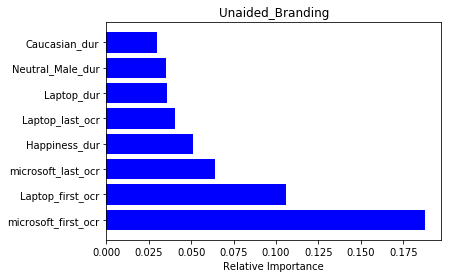

In [20]:
model.plot_feature_importance(models_1,10,y_train_1.columns,X_train_1.columns,savefig=False)

In [23]:
model_xgb = Model('xgb')
print("------------------------ XGB Unaided Model Training ----------------------------\n")
models_xgb_1 = model_xgb.train(X_train_1,y_train_1,X_test_1,y_test_1,metrics='r2',plot_error=False)

------------------------ XGB Unaided Model Training ----------------------------

Unaided_Branding


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.4s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.7s finished


For training set
r2_score: 0.934300
For test set
r2_score: 0.966209




Unaided_Branding
Lenovo Yoga 910_dur
Yoga_dur
ASUS T102_dur
Windows 10, Windows_dur
Dell PCs_dur
Windows 10, HP_Spectre_dur
Windows 10_total_ocr
microsoft_first_ocr
Windows 10_first_ocr
Dell XPS 13_dur
Windows 10_last_ocr
Windows_dur
HP Spectre x360, Windows_dur
Windows 10 PCs_dur
microsoft_last_ocr
Tablet_dur
Surface Book_dur
Windows 10_dur
Happiness_length_of_ad_impact
Surface_first_ocr
Happiness_Female_dur
Tablet_last_ocr
Neutral_Male_dur
Laptop_first_ocr
Surface_last_ocr
Tablet_total_ocr
Surface_total_ocr
Laptop_last_ocr
Laptop_total_ocr
Laptop_dur
Surface_dur
length_of_ad_15
Surface Go_dur
ad_type_tv
Caucasian_dur
HP Spectre x360_dur
Neutral_dur
Neutral_Age: 25-34_dur
Tablet_first_ocr
microsoft_total_ocr
microsoft_dur
Happiness_dur
Lenovo Yoga 720_dur
African_dur
Happiness_Eastasian_dur
Windows 10 PC_dur
Eastasian_dur
Age: 25-34_African_dur
Male_dur
Age: 25-34_Eastasian_dur
Suface Laptop_dur
Female_dur
Age: 25-34_Caucasian_dur
Macbook Air_dur
Age: 35-44_dur
Sadness_dur
Age: 25-34_

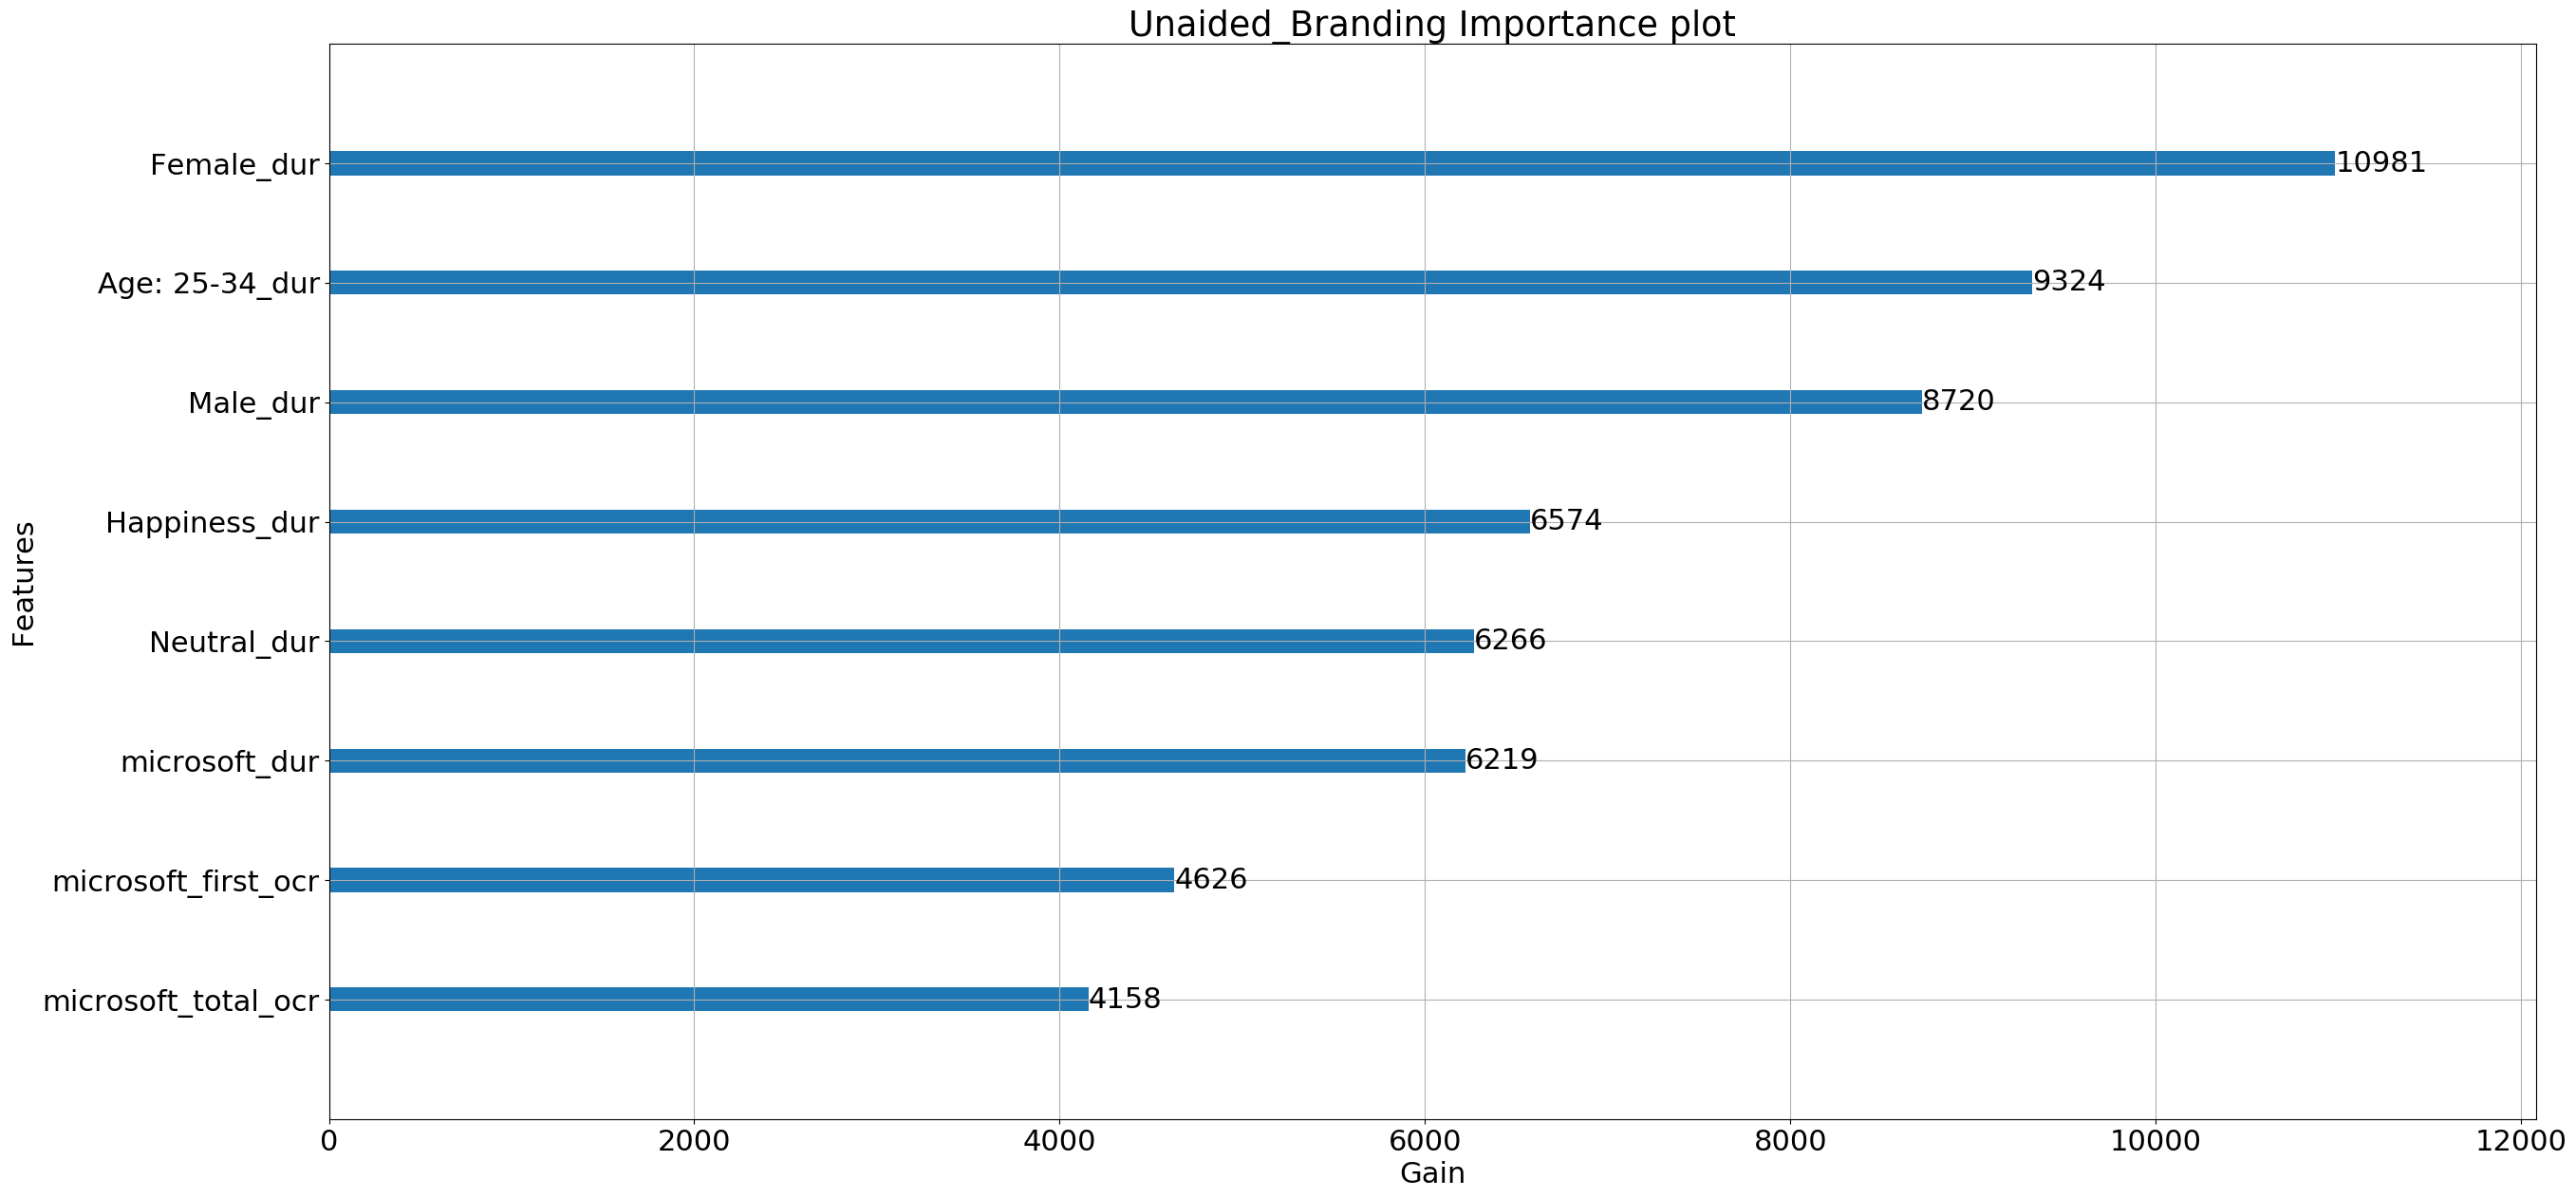

In [45]:
model_xgb.plot_feature_importance(models_xgb_1,10,y_train_1.columns,X_train_1.columns,savefig=False)

In [66]:
from tqdm import tqdm
shap.initjs()
explainer=[]
shap_values=[]
for i in tqdm(range(1)):
    explainer.append(shap.TreeExplainer(models_1[i]))
    shap_values.append(explainer[-1].shap_values(X_train_1))
    
    print(i)

100%|██████████| 1/1 [00:04<00:00,  4.77s/it]

0


In [26]:
req_cols = [
'microsoft_first_ocr',
'Laptop_first_ocr',
'microsoft_last_ocr',
'Happiness_dur',
'Laptop_last_ocr',
'Laptop_dur',
'Neutral_Male_dur',
'Caucasian_dur',
'length_of_ad_15',
'Happiness_Female_dur',
'Female_dur'
]

In [65]:

model.shap_analysis(shap_values,X_train_1,y_train_1.columns,X_train_1.columns,n_features=11,required_cols=req_cols)

,Unaided_Branding,Unaided_Branding_val
0,microsoft_first_ocr,0.971831
1,Laptop_first_ocr,0.41129
2,microsoft_last_ocr,0.711491
3,Happiness_dur,1.20126
4,Laptop_last_ocr,0.75
5,Laptop_dur,0.380671
6,Neutral_Male_dur,0.977401
7,Caucasian_dur,1.39726
8,length_of_ad_15,0.772152
9,Happiness_Female_dur,1.30263


In [70]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(models_1[0], random_state=1).fit(X_train_1, y_train_1)
eli5.show_weights(perm, feature_names = X_train_1.columns.tolist())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

Weight,Feature
0.2107 ± 0.0199,microsoft_first_ocr
0.0849 ± 0.0118,microsoft_last_ocr
0.0450 ± 0.0053,Laptop_first_ocr
0.0429 ± 0.0059,length_of_ad_15
0.0406 ± 0.0049,Laptop_last_ocr
0.0322 ± 0.0069,Happiness_dur
0.0318 ± 0.0073,Happiness_Female_dur
0.0269 ± 0.0055,Female_dur
0.0238 ± 0.0019,Laptop_dur
0.0220 ± 0.0026,Happiness_length_of_ad_impact


In [38]:
col = 'Caucasian_dur'
X_train_1[col].mean()

1.8800989509212287

In [58]:
a = np.array([1,2,3,4,5])

In [60]:
a.std()

1.4142135623730951

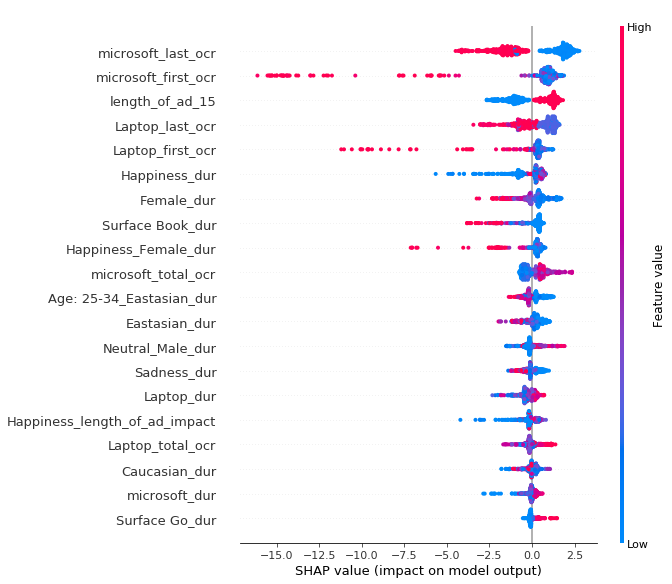

In [55]:
shap.summary_plot(shap_values[0],X_train_1)

In [60]:
X_train_14.to_excel('../../Version_1.01/x_train_14.xlsx')

In [61]:
X_test_14.to_excel('../../Version_1.01/x_test_14.xlsx')
y_train_14.to_excel('../../Version_1.01/y_train_14.xlsx')
y_test_14.to_excel('../../Version_1.01/y_test_14.xlsx')

In [62]:
X_train_4.to_excel('../../Version_1.01/x_train_4.xlsx')
X_test_4.to_excel('../../Version_1.01/x_test_4.xlsx')
y_train_4.to_excel('../../Version_1.01/y_train_4.xlsx')
y_test_4.to_excel('../../Version_1.01/y_test_4.xlsx')